# A study on a square dielectric waveguide using MEEP

In these notes, we calculate the electric field, Green's function and modified spontaneous emission rate of an atom in presence of a square dielectric waveguide running [MEEP](http://ab-initio.mit.edu/wiki/index.php/Meep). 

This is an [IJulia notebook](https://github.com/JuliaLang/IJulia.jl), which provides a nice
browser-based [Jupyter](http://jupyter.org/) interface to the [Julia language](http://julialang.org/), a high-level dynamic language (similar to Matlab or Python+SciPy) for technical computing.  The notebook allows us to combine code and results in one place.


## 3d dielectric waveguide

Our simulation is based on the file `sqwg.ctl` in the same folder, which computes the e-field components of a square waveguide over time. The waveguide has a square cross-section of a width=0.3 ($\mu m$ is the unit of length) and a index of refraction of $n_{core}=1.98$ in vacuum. We use the [unit convention of MEEP](http://ab-initio.mit.edu/wiki/index.php/Meep_Introduction#Units_in_Meep) throughout this notebook, that is to treat the speed of light in vacuum $c=1$ and use a unit length $a=1\mu m$.

Let me assume you are running on a machine with `meep-mpi` installed.  It is easy to install on Ubuntu Linux with `apt-get install meep meep-mpi h5utils`.  There is also a Python interface of MEEP which can be installed using [Filip Dominec's scropt](https://github.com/FilipDominec/python-meep-install) on a Linux/Unix machine. 

To plot out the results, it requires `HDF5` and `PyPlot` in Julia. You can add these packages by running `Pkg.add("HDF5")`, for example, in Julia or in this notebook. 

At the shell, we would normally run `meep-mpi "sqwg.ctl" > sqwg.out`, but we can also do this directly from Julia with the `run` and `pipeline` functions. As I am using a multi-core machine, I will also use MPI to accelerate the computation by using `mpirun -n` where `-n` switch specifies the number of cores in using for the computing.

In [1]:
run(pipeline(`mpirun -n 6 meep-mpi "sqwg.ctl"`, "sqwg.out"))


Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecate

The `sqwg.out` file is now a dump of all the output from the `meep-mpi` run, basically a log of the computational process. Intermingled in this output are a sequence of lines beginning with prefixes like `creating output file ` which contain quatation-mark-delimited text of the data output file names.

To pull out this data file names at a Unix command-line, the easiest thing is to use the `grep` command (which extracts lines matching a certain pattern) combined with the `cut` command (to strip out the quatation marks or delimiters, leaving only the content inside of the pairs of quatation marks).  We also need to cut the `./` string from each line. We can extract these to a file `datafilenames.dat` at the command line by `grep "creating output file " sqwg.out | cut -d '"' -f2 | cut -d'/' -f2- > datafilenames.dat`, or in Julia by:

In [2]:
run(pipeline(`grep "creating output file " sqwg.out`, `cut -d '"' -f2`, `cut -d'/' -f2-`, "datafilenames.dat"))

# display the contents of the resultying `datafilenames.dat` file:
println(readstring("datafilenames.dat"))

sqwg-Ert.h5
sqwg-eps-000000.00.h5
sqwg-ex-000040.00.h5
sqwg-ey-000040.00.h5
sqwg-ez-000040.00.h5
sqwg-ex-000080.00.h5
sqwg-ey-000080.00.h5
sqwg-ez-000080.00.h5
sqwg-ex-000120.00.h5
sqwg-ey-000120.00.h5
sqwg-ez-000120.00.h5
sqwg-ex-000160.00.h5
sqwg-ey-000160.00.h5
sqwg-ez-000160.00.h5
sqwg-ex-000200.00.h5
sqwg-ey-000200.00.h5
sqwg-ez-000200.00.h5
sqwg-ex-000240.00.h5
sqwg-ey-000240.00.h5
sqwg-ez-000240.00.h5



Finally, we can read in this data as a matrix of numbers by the `readcsv` function in Julia (csv = [comma-separated values](https://en.wikipedia.org/wiki/Comma-separated_values)), where the `header=true` option means that it reads the first line as list of strings describing each column, followed by data on subsequent lines:

In [3]:
datafilenames = readcsv("datafilenames.dat", header=false)

20×1 Array{Any,2}:
 "sqwg-Ert.h5"          
 "sqwg-eps-000000.00.h5"
 "sqwg-ex-000040.00.h5" 
 "sqwg-ey-000040.00.h5" 
 "sqwg-ez-000040.00.h5" 
 "sqwg-ex-000080.00.h5" 
 "sqwg-ey-000080.00.h5" 
 "sqwg-ez-000080.00.h5" 
 "sqwg-ex-000120.00.h5" 
 "sqwg-ey-000120.00.h5" 
 "sqwg-ez-000120.00.h5" 
 "sqwg-ex-000160.00.h5" 
 "sqwg-ey-000160.00.h5" 
 "sqwg-ez-000160.00.h5" 
 "sqwg-ex-000200.00.h5" 
 "sqwg-ey-000200.00.h5" 
 "sqwg-ez-000200.00.h5" 
 "sqwg-ex-000240.00.h5" 
 "sqwg-ey-000240.00.h5" 
 "sqwg-ez-000240.00.h5" 

The first file is the meshgrid data of $\epsilon$ or the electric permitivity of the waveguide in space. 

Now, let's plot the dispersion relation.  I'll use the [PyPlot](https://github.com/stevengj/PyPlot.jl) package in Julia, which is an interface to the sophisticated [matplotlib](http://matplotlib.org/) Python plotting library.   We'll plot three things:

* The waveguide structure in terms of $\epsilon$.
* Plot the light field components.
* Calculate the waveguide-modified spontaneous decay rate for the dipole.



Next, we'll do the same thing for the cases that the dipole is orientated in other directions and placed in different locations.

### Plotting the index of refraction profile of the waveguide

MEEP needs to mesh the grid of the simulation cell to perform the computation. It is good to plot out the mesh of index of refraction in space and find out how good is the mesh resolution. This can be done by plotting out the output eps file in a standard [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) format, which ends in `.h5`.  A single HDF5 file can contain multiple "datasets", e.g. multiple field components or real+imaginary parts.

In `sqwg.ctl`, we request some eps (or square of the index of refraction) output by a line `((at-beginning output-epsilon))` at the end of the file, which performs a simple meshing computation at the beginning and outputs $\varepsilon(x,y,z)$.
It is a good idea to check this file (plot $\varepsilon$) to make sure the structure is what you think it is.  We can use the `h5ls` command-line tool to see what is inside this file:

In [4]:
run(`h5ls sqwg-eps-000000.00.h5`)

eps                      Dataset {189, 189, 210}


MEEP in general supports a $3\times3$ anisotropic $\varepsilon$ tensor, and the file contains all of the components of this (symmetric) tensor and its inverse.   However, for the most part we are just interested in `eps`, which is a "scalarized" $\varepsilon$ formed from the average eigenvalue of $\varepsilon$.

Any serious technical language or plotting package these days supports HDF5.  In Julia's case, we can read HDF5 through the [HDF5](https://github.com/JuliaLang/HDF5.jl) package, using the `h5read(filename, dataset)` function. It actually reads the dataset of eps in a reversed order of $(x,y,z)$ dimensions so that we need to permute the dimensions backwards before plotting: 

sqwg-eps-000000.00.h5(

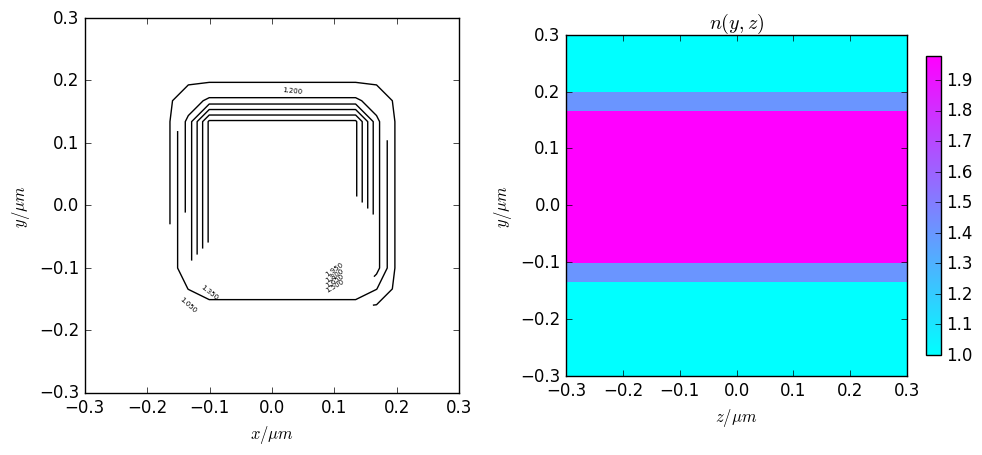

189,189,210)

PyObject <matplotlib.text.Text object at 0x7ff77c4da4d0>

In [5]:
using PyPlot
using HDF5
filename=datafilenames[2]
print(filename)
ɛ = h5read(join(filename), "eps") #"sqwg-eps-000000.00.h5","eps")
ɛ = permutedims(ɛ,[3,2,1])
print(size(ɛ))
lenx = length(ɛ[:,63,70])
leny = length(ɛ[63,:,70])
lenz = length(ɛ[63,63,:])
#println(convert(Int64,floor(lenz/2)))
x = linspace(-3.15,3.15, lenx)
y = linspace(-3.15,3.15, leny)
z = linspace(-3.5,3.5, lenz)
xygrid = repmat(x',leny,1)
yxgrid = repmat(y,1,lenx)
zygrid = repmat(z',leny,1)
yzgrid = repmat(y,1,lenz)

fig = figure("index of refraction plot",figsize=(10,10))
ax = fig[:add_subplot](1,2,1)
cp = ax[:contour](xygrid, yxgrid, sqrt(ɛ[:,:,ceil(Int64,lenz/2)]), colors="black", linewidth=2.0)
ax[:clabel](cp, inline=1, fontsize=5)
#ax = fig[:add_subplot](1,2,1,projection="3d")
#cp = ax[:plot_surface](xygrid, yxgrid, sqrt(ɛ[:,:,70]),rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.8, linewidth=0.2)
#contourf(X,Y, ɛ[:,:,70])
xlabel(L"x/\mu m")
ylabel(L"y/\mu m")
axis("image")
xlim(-0.3,0.3)
ylim(-0.3,0.3)
tight_layout()
gcf() # Needed for IJulia to plot inline

subplot(1,2,2)
ax = fig[:add_subplot](1,2,2)
#cp = ax[:contour](zygrid, yzgrid, squeeze(sqrt(ɛ[63,:,:]),1), colors="black", linewidth=1.0)
#ax[:clabel](cp, inline=1, fontsize=1)
#ax = fig[:add_subplot](1,2,2,projection="3d")
#cp = ax[:plot_surface](zygrid, yzgrid, squeeze(sqrt(ɛ[63,:,:]),1),rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.8, linewidth=0.2)
pcolor(zygrid, yzgrid, sqrt(ɛ[ceil(Int64,lenx/2),:,:]), cmap="cool")
colorbar(;orientation="vertical",fraction=0.04)
xlabel(L"z/ \mu m")
ylabel(L"y/ \mu m")
axis("image")
xlim(-0.3,0.3)
ylim(-0.3,0.3)
tight_layout()
#gcf() # Needed for IJulia to plot inline
title(L"n(y,z)")

As expected, $\sqrt{\varepsilon}=n$ is 2 in the middle and 1 elsewhere with a gradual changes around the edges.  Now let's read the fields.


# Plotting the field intensity at different times

For example, `sqwg-ex-000010.00.h5` contains the electric field (`ex`) at the 10th unit time, the unit time is defined by $T=\frac{a}{c}$ with $a=1\mu m$ being the unit length and $c=1$ being the speed of light in vacuum. It contains only one dataset, `ex`, which is the real part of the $E_x$ field. 

In [11]:
run(`h5ls sqwg-ex-000040.00.h5`)

ex.i                     Dataset {189, 189, 210}
ex.r                     Dataset {189, 189, 210}


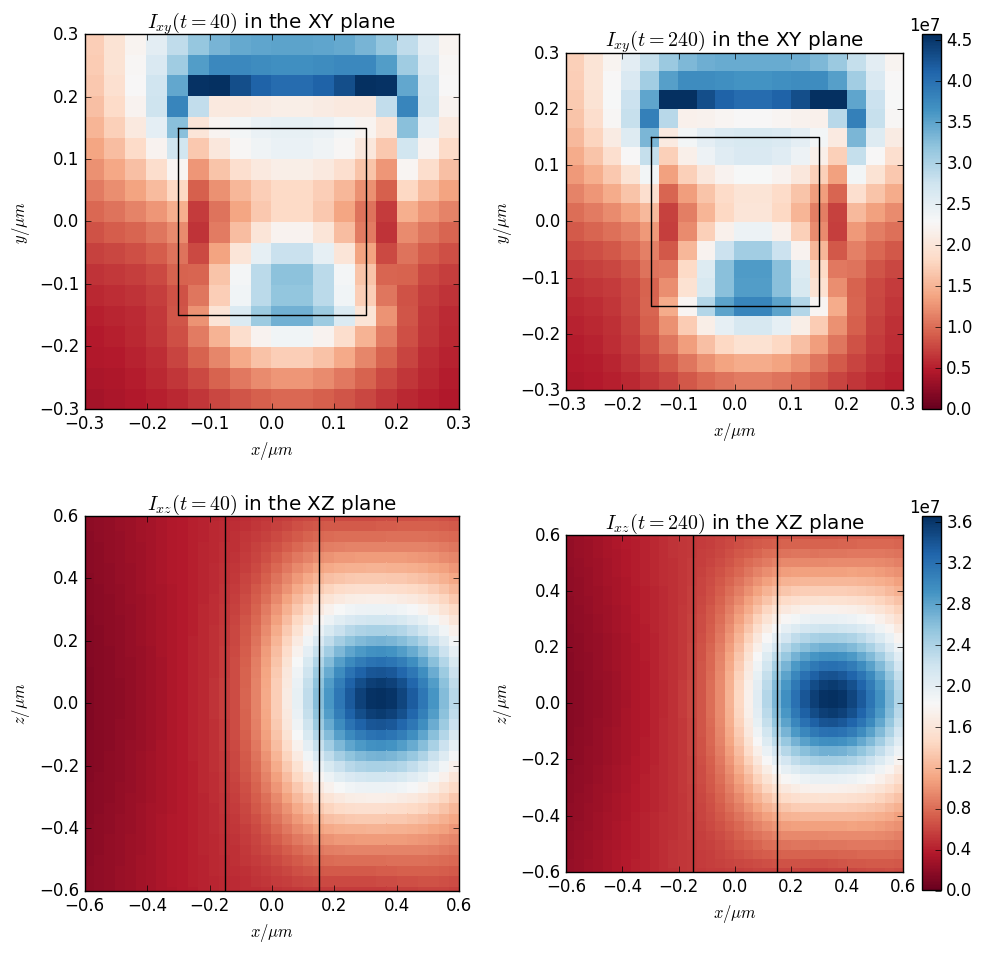

(189,210)
(189,210)


In [12]:
# Plot the Ex component in the cross sections.
xzgrid = repmat(x,1,lenz); zxgrid = repmat(z',lenx,1)
println(size(xzgrid)); println(size(zxgrid))
# Read out the Ex, Ey and Ez data at time 10 (all real in the simulation).
ex = h5read(join(datafilenames[3]), "ex.r") + im*h5read(join(datafilenames[3]), "ex.i")
ex = permutedims(ex,[3,2,1])
# println(ex[1]) # To verify if this is a real number.
ey = h5read(join(datafilenames[4]), "ey.r") + im*h5read(join(datafilenames[4]), "ey.i")
ey = permutedims(ey,[3,2,1])
ez = h5read(join(datafilenames[5]), "ez.r") + im*h5read(join(datafilenames[5]), "ez.i")
ez = permutedims(ez,[3,2,1])
Int10 = abs(ex).^2+abs(ey).^2+abs(ez).^2;
Int10z0 = Int10[:,:,ceil(Int64,lenz/2)+10]; # The xy-plane intensity at the 10th slice on the z-direction off the origin.
maxInt10z0 = maximum(Int10z0[:]);
Int10y0 = Int10[:,ceil(Int64,leny/2)+10,:]; # The xz-plane intensity at the 10th slice on the y-direction off the origin.

# Read out the data at time 240.
ex = h5read(join(datafilenames[18]), "ex.r") + im*h5read(join(datafilenames[18]), "ex.i")
ex = permutedims(ex,[3,2,1])
ey = h5read(join(datafilenames[19]), "ey.r") + im*h5read(join(datafilenames[19]), "ey.i")
ey = permutedims(ey,[3,2,1])
ez = h5read(join(datafilenames[20]), "ez.r") + im*h5read(join(datafilenames[20]), "ez.i")
ez = permutedims(ez,[3,2,1])
Int60 = abs(ex).^2+abs(ey).^2+abs(ez).^2;
Int60z0 = Int60[:,:,ceil(Int64,lenz/2)+10]; # The intensity at the 10th slice on the z-direction off the origin.
Int60y0 = Int60[:,ceil(Int64,leny/2)+10,:]; # The xz-plane intensity at the 10th slice on the y-direction off the origin.

# Define the border of the waveguide on xy and xz cross-sections.
wglen=0.3;
xy_border_x=[-wglen/2.,wglen/2.,wglen/2.,-wglen/2.,-wglen/2.]
xy_border_y=[wglen/2.,wglen/2.,-wglen/2.,-wglen/2.,wglen/2.]
xz_border1_x=[-wglen/2.,-wglen/2.]
xz_border1_z=[-1,1]
xz_border2_x=[wglen/2.,wglen/2.]
xz_border2_z=[-1,1]
fig = figure("index of refraction plot",figsize=(10,10))
ax = fig[:add_subplot](2,2,1)
pcolor(xygrid,yxgrid,Int10z0./maxInt10z0, cmap="RdBu")
#colorbar(;orientation="vertical",fraction=0.04)
plot(xy_border_x,xy_border_y,"-k")
title("\$I_{xy}(t=40)\$ in the XY plane")
xlabel(L"x/ \mu m")
ylabel(L"y/ \mu m")
axis("image")
xlim(-0.3,0.3)
ylim(-0.3,0.3)
tight_layout()

subplot(2,2,2)
ax = fig[:add_subplot](2,2,2)
pcolor(xygrid,yxgrid,Int60z0./maxInt10z0, cmap="RdBu")
colorbar(;orientation="vertical",fraction=0.05)
plot(xy_border_x,xy_border_y,"-k")
title("\$I_{xy}(t=240)\$ in the XY plane")
xlabel(L"x/ \mu m")
ylabel(L"y/ \mu m")
axis("image")
xlim(-0.3,0.3)
ylim(-0.3,0.3)
tight_layout()

subplot(2,2,3)
ax = fig[:add_subplot](2,2,3)
pcolor(xzgrid,zxgrid,Int10y0./maxInt10z0, cmap="RdBu")
#colorbar(;orientation="vertical",fraction=0.05)
plot(xz_border1_x,xz_border1_z,"-k")
plot(xz_border2_x,xz_border2_z,"-k")
title("\$I_{xz}(t=40)\$ in the XZ plane")
xlabel(L"x/ \mu m")
ylabel(L"z/ \mu m")
axis("image")
xlim(-0.6,0.6)
ylim(-0.6,0.6)
tight_layout()

subplot(2,2,4)
ax = fig[:add_subplot](2,2,4)
pcolor(xzgrid,zxgrid,Int60y0./maxInt10z0, cmap="RdBu")
colorbar(;orientation="vertical",fraction=0.05)
plot(xz_border1_x,xz_border1_z,"-k")
plot(xz_border2_x,xz_border2_z,"-k")
title("\$I_{xz}(t=240)\$ in the XZ plane")
xlabel(L"x/ \mu m")
ylabel(L"z/ \mu m")
axis("image")
xlim(-0.6,0.6)
ylim(-0.6,0.6)
tight_layout()

We can also plot a ***slice*** view in a 3D fashion as below.

## Local field evolution

This should be obtained by setting up a point-monitor at the dipole position and append time-dependent field components in some short periods.

Now we can see more easily that the fields are oscillating within the waveguide and are exponentially decaying outside the waveguide.

In [8]:
run(`h5ls sqwg-Ert.h5`)

ex.i                     Dataset {1200/Inf}
ex.r                     Dataset {1200/Inf}
ey.i                     Dataset {1200/Inf}
ey.r                     Dataset {1200/Inf}
ez.i                     Dataset {1200/Inf}
ez.r                     Dataset {1200/Inf}


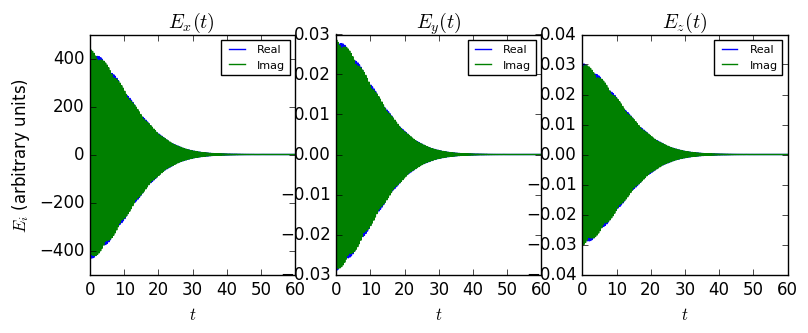

(1200,)


PyObject <matplotlib.legend.Legend object at 0x7ff75eca0790>

In [13]:
using PyPlot
using HDF5
ex = h5read("sqwg-Ert.h5", "ex.r") + im*h5read("sqwg-Ert.h5", "ex.i")
ey = h5read("sqwg-Ert.h5", "ey.r") + im*h5read("sqwg-Ert.h5", "ey.i")
ez = h5read("sqwg-Ert.h5", "ez.r") + im*h5read("sqwg-Ert.h5", "ez.i")
println(size(ex))
lent=length(ex)
ex = ex[end:-1:1]; ey = ey[end:-1:1]; ez = ez[end:-1:1];
t=linspace(0,60.0,lent)
figure(figsize=(9,3))
subplot(1,3,1)
ax=plot(t,real(ex))
plot(t,imag(ex))
title("\$E_x(t)\$ ")
xlabel(L"t")
ylabel(L"$E_i$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,2)
ax=plot(t,real(ey))
plot(t,imag(ey))
title("\$E_y(t)\$")
xlabel(L"t")
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,3)
ax=plot(t,real(ez))
plot(t,imag(ez))
title("\$E_z(t)\$")
xlabel(L"t")
#ylabel(L"$E_z$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

Now we can plot out the detected signal in the frequency domain correspondingly.

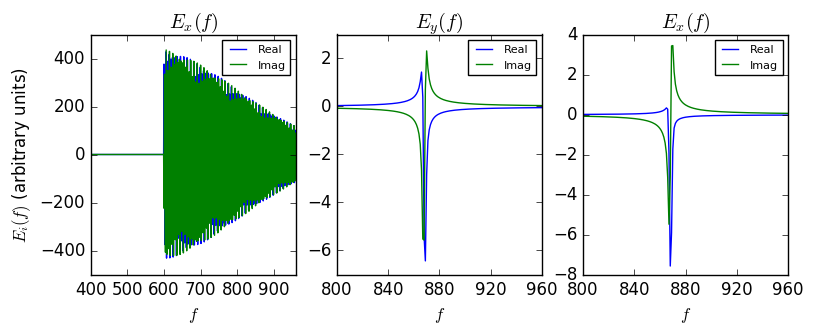

PyObject <matplotlib.legend.Legend object at 0x7ff764d4cbd0>

In [14]:
ex_f=fft(ex); ey_f=fft(ey); ez_f=fft(ez);
ex_f=fftshift(ex); ey_f=fftshift(ey_f); ez_f=fftshift(ez_f); # Have to shift the frequency domain data for complex singal. See: http://www.exegetic.biz/blog/2015/10/monthofjulia-day-37-fourier-techniques/ 
figure(figsize=(9,3))
subplot(1,3,1)
plot(real(ex_f))
plot(imag(ex_f))
xlabel(L"f")
xlim([400,960])
ylabel(L"$E_i(f)$ (arbitrary units)")
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,2)
plot(real(ey_f))
plot(imag(ey_f))
xlabel(L"f")
xlim([800,960])
xticks(linspace(800,960,5))
title("\$E_y(f)\$")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,3)
plot(real(ez_f))
plot(imag(ez_f))
xlabel(L"f")
xlim([800,960])
xticks(linspace(800,960,5))
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=8)